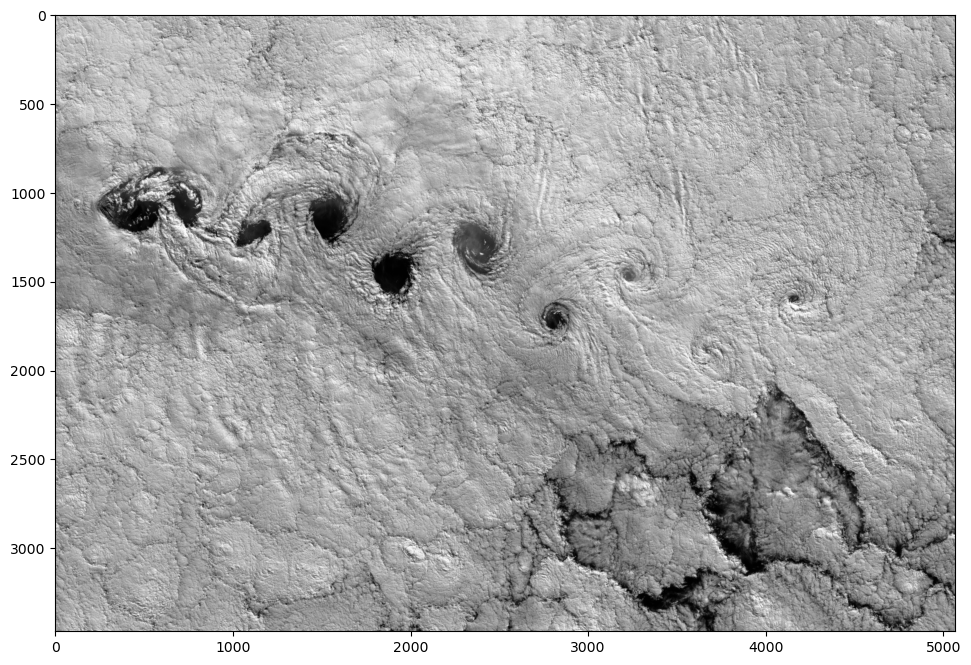

In [1]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import os
plt.rcParams['figure.figsize'] = [16,8]
A =imread(os.path.join('.','Karman_vortex.jpg'))
X = np.mean(A,-1); # Convert RGB to grayscale
img = plt.imshow(X)
img.set_cmap('gray')
plt.show()

1. Compute the economy SVD.

In [2]:
U, s, VT = np.linalg.svd(X, full_matrices=False)

2. Let X be the matrix representing the true image and $\widetilde{X}$ the approximation of rank r obtained using the
SVD. Compute and plot the relative reconstruction error of the truncated SVD in the Frobenius norm as
a function of the rank r. The expression of the relative reconstruction error is given by:

<p style="text-align: center;">
    \begin{equation}
    \frac{∥X − \widetilde{X}∥_F}
    {∥X∥_F}
    \end{equation}
</p>



  0%|          | 0/61 [00:00<?, ?it/s]

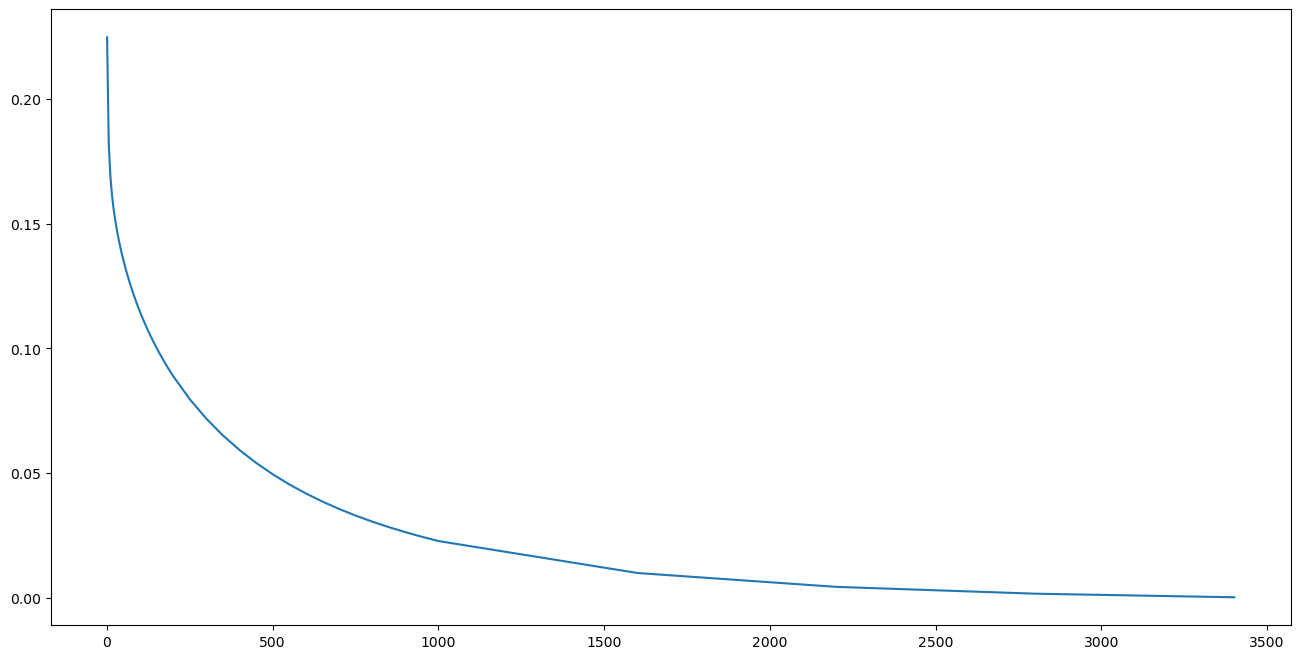

In [9]:
from tqdm.notebook import tqdm
def reconstruct(U, s, VT, rank):
    return np.matmul(U[:,:rank], np.matmul(np.diag(s[:rank]),VT[:rank,:]))

def reconstruction_error(X, X_approx):
    return np.linalg.norm(X-X_approx, ord='fro')/np.linalg.norm(X, ord='fro')

rank = np.arange(1, 201,5)
rank = np.append(rank, np.arange(201, 1501, 100))
rank = np.append(rank, np.arange(1001, 3468, 700))
errors = []
for r in tqdm(rank):
    errors.append(reconstruction_error(X, reconstruct(U, s, VT, r)))
    
plt.plot(rank, errors)

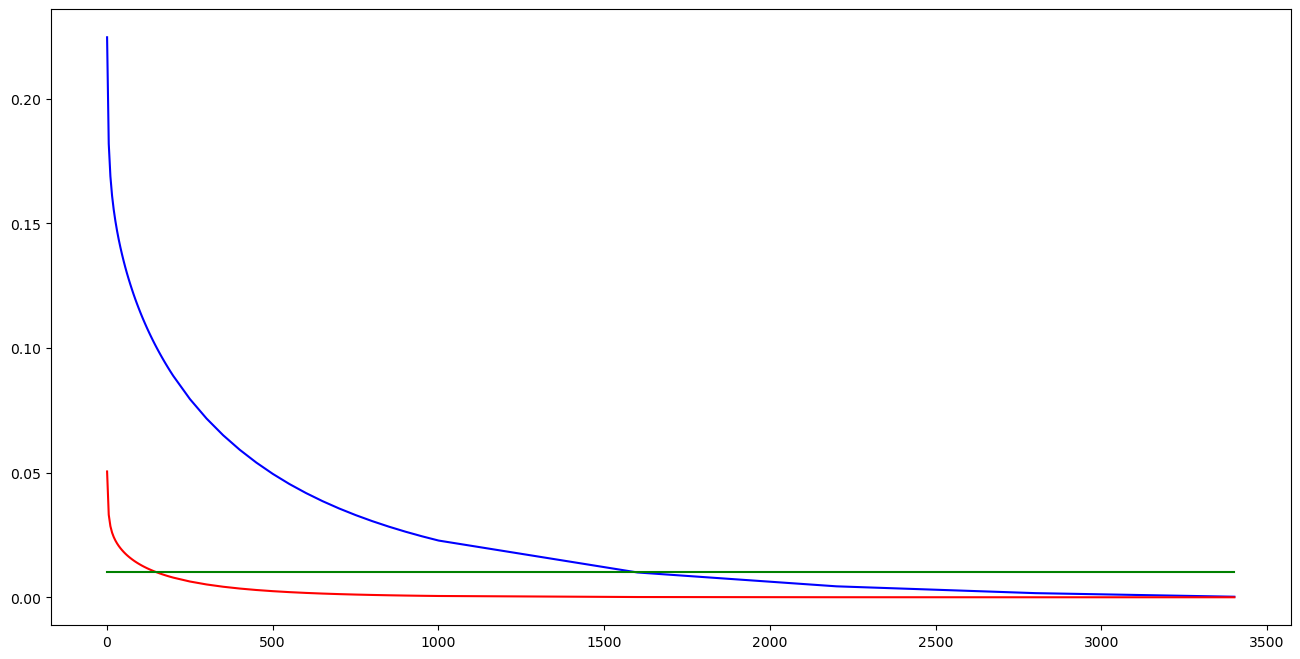

In [10]:
variances = []
for error in errors:
    variances.append(error**2)

plt.plot(rank, errors, color='blue')
plt.plot(rank, variances, color='red')
plt.plot(rank, np.ones(len(rank))*0.01, color='green')

In [33]:
low_ranks = np.arange(140, 300, 1)
for r in low_ranks:
    unexplained_variance = reconstruction_error(X, reconstruct(U, s, VT, r))**2
    if unexplained_variance <= 0.01:
        searched_rank = r
        break
print('searched rank is: ', r)
print('explained variance is: ', 1 - unexplained_variance)


searched rank is:  152
explained variance is:  0.9900478974300589


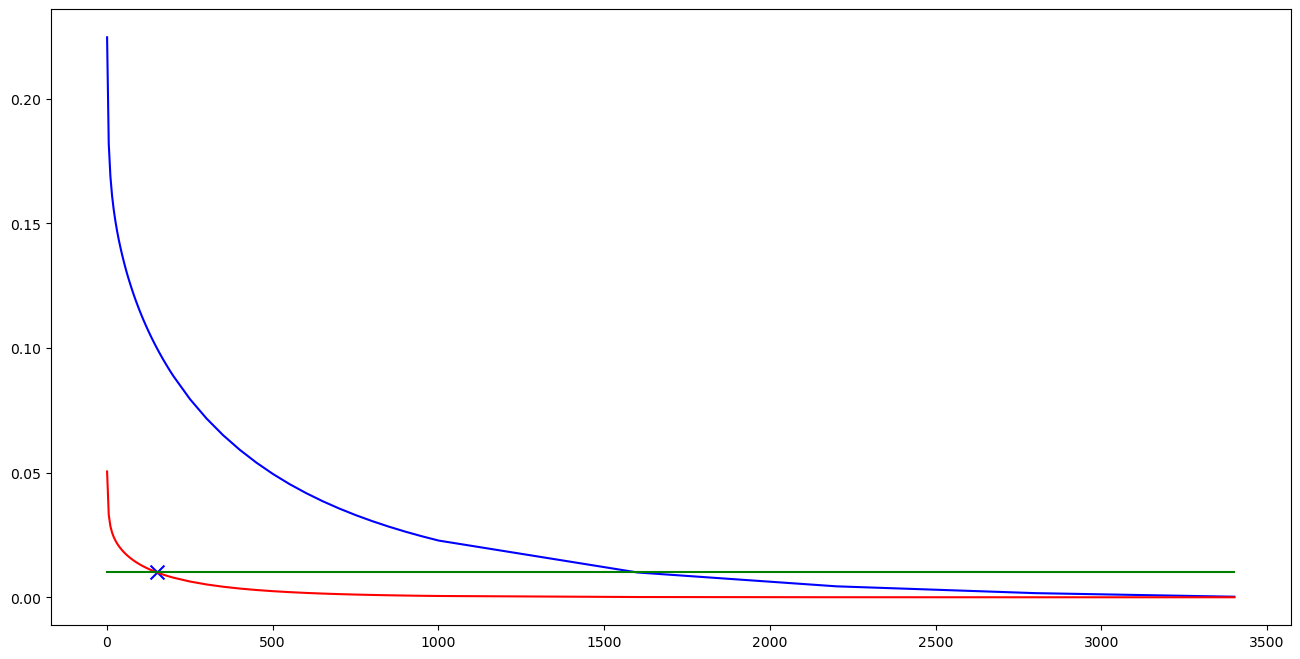

In [34]:
plt.plot(rank, errors, color='blue')
plt.plot(rank, variances, color='red')
plt.plot(rank, np.ones(len(rank))*0.01, color='green')
plt.scatter(r, unexplained_variance, color='blue', marker='x', s=100)

## Exercise 2
Generate 100 artificial data points (xi , yi ) where xi is randomly generated in the interval [0, 1] and yi =
cos(4πxi ) + ϵ; ϵ is a random noise in the interval [−0.2, 0.2].

Implement the SGD method to solve the regression problem for the data you have generated. 

Use an initial constant learning rate η = 0.001 an train a polynomial of the form hc = c0 + c1 x + c2 x2 + . . . + cn xn using your data (n is the maximum degree of the polynomial).

Assume that all the initial parameters ci are randomly generated in [−0.4, 0.4]. Try different values of n.

Try also different values for α to speed up the learning process. Plot the various results and comment them.

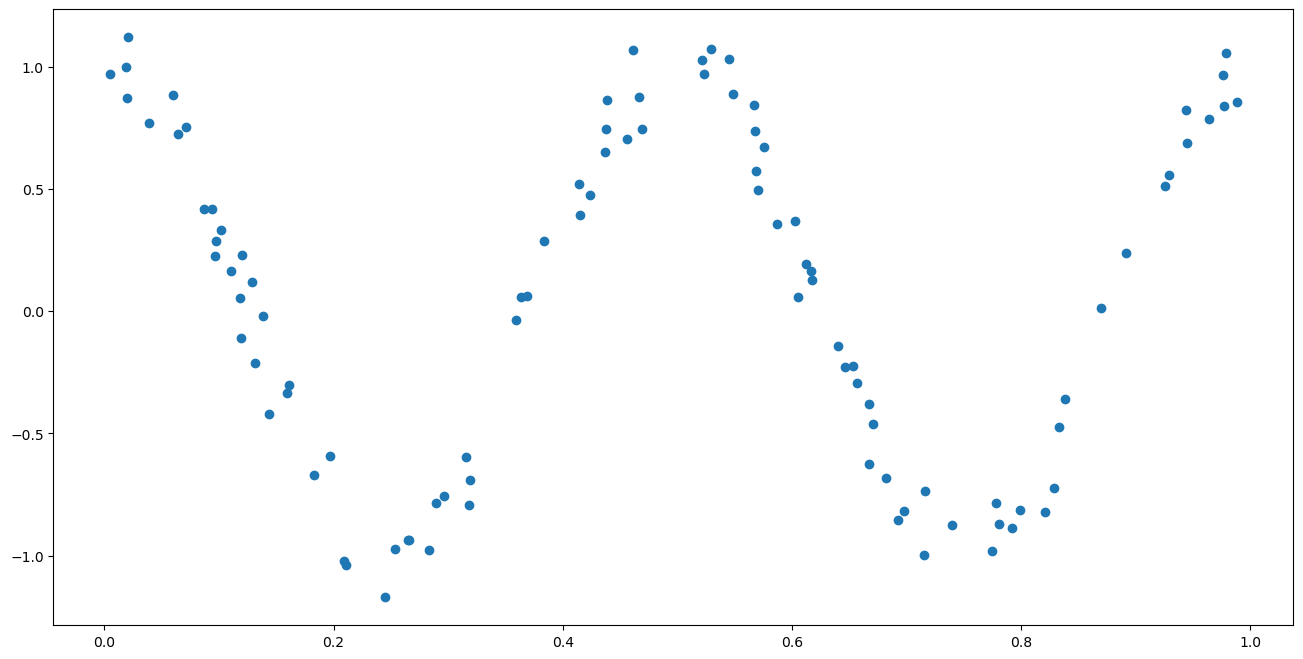

In [37]:
import math

np.random.seed(0)
x = np.random.rand(100)
y = np.ones(len(x))
epsilons = []
for i in range(len(y)):
    y[i] = math.cos(4*math.pi*x[i]) + (np.random.rand(1)[0]-0.5)*0.4

plt.scatter(x, y)

In [36]:
from tqdm.notebook import tqdm
import jax
import jax.numpy as jnp

def evaluate_polinomial(x, params):
    out = jnp.zeros(len(x))
    for i in range(len(params)):
        out += jnp.power(x, i)*params[i]
    return out

def loss(x, y, params):
  error =  evaluate_polinomial(x, params) - y
  return jnp.mean(error * error)

def initialize_params(n):
    params = []
    for i in range(n+1):
        params.append((np.random.rand(1)[0] - 0.5)*0.8)
    return params

def SGD(n, learning_rate, x_train, y_train, params, grad_jit, loss_jit):
    history_train = list()
    history_train.append(loss_jit(x_train, y_train, params))
    
    for epoch in range(num_epochs):
        idxs = np.random.choice(n_samples, batch_size)
        grads = grad_jit(x_train[idxs], y_train[idxs], params)
        
        for i in range(len(params)):
            params[i] -= learning_rate * grads[i]
    
        history_train.append(loss_jit(x_train, y_train, params))
    return params, history_train


  0%|          | 0/5 [00:00<?, ?it/s]

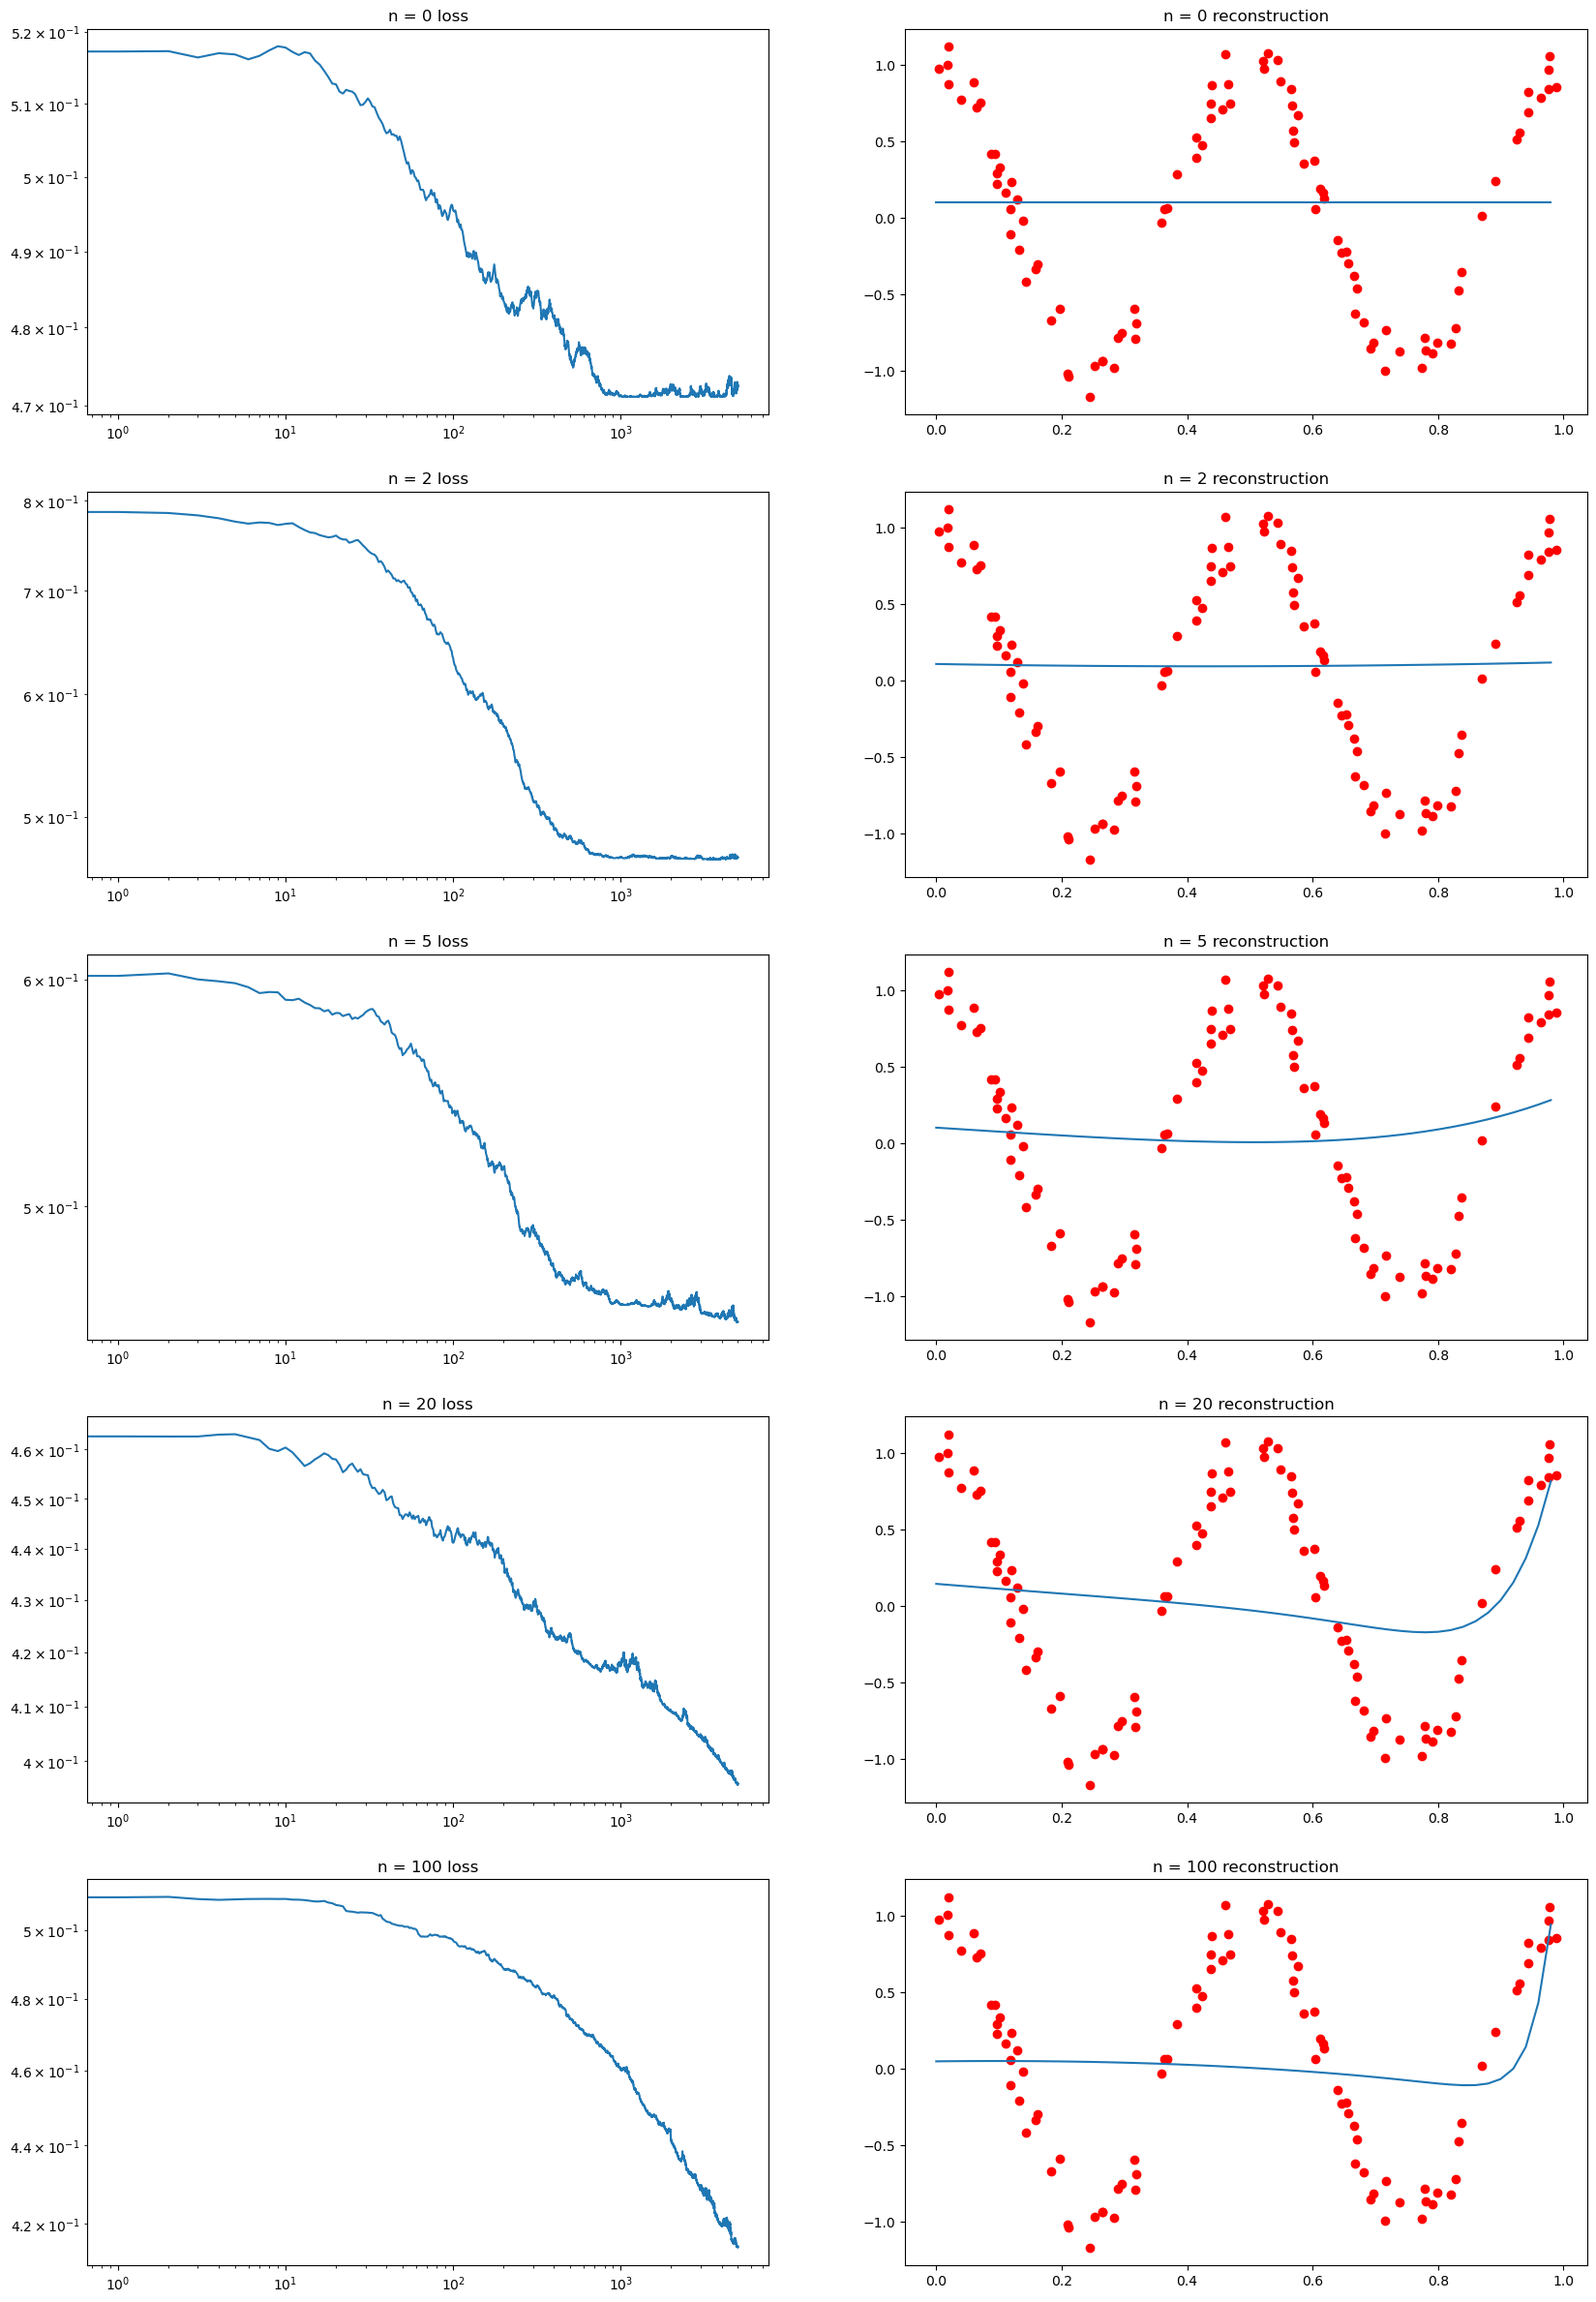

In [38]:
eta = 1e-3
n_array = np.array([0,2,5, 20, 100])
num_epochs = 5000
n_samples = len(x)
batch_size = 1 #plain SGD

fig, axs = plt.subplots(nrows=len(n_array), ncols=2, figsize=(20,30))

grad = jax.jit(jax.grad(loss, argnums = 2))
loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)
i = 0
for n in tqdm(n_array):
    params, history_train = SGD(n, eta, x, y, initialize_params(n), grad_jit, loss_jit)
    
    axs[i][0].loglog(history_train, label = 'train')
    axs[i][0].set_title(f'n = {n} loss')

    baseline = np.arange(0, 1, 2e-2)
    axs[i][1].scatter(x, y, color='red')
    axs[i][1].plot(baseline, evaluate_polinomial(baseline, params))
    axs[i][1].set_title(f'n = {n} reconstruction')
    i += 1

  0%|          | 0/5 [00:00<?, ?it/s]

best learning rate is: 0.01 with loss: 0.3244481682777405


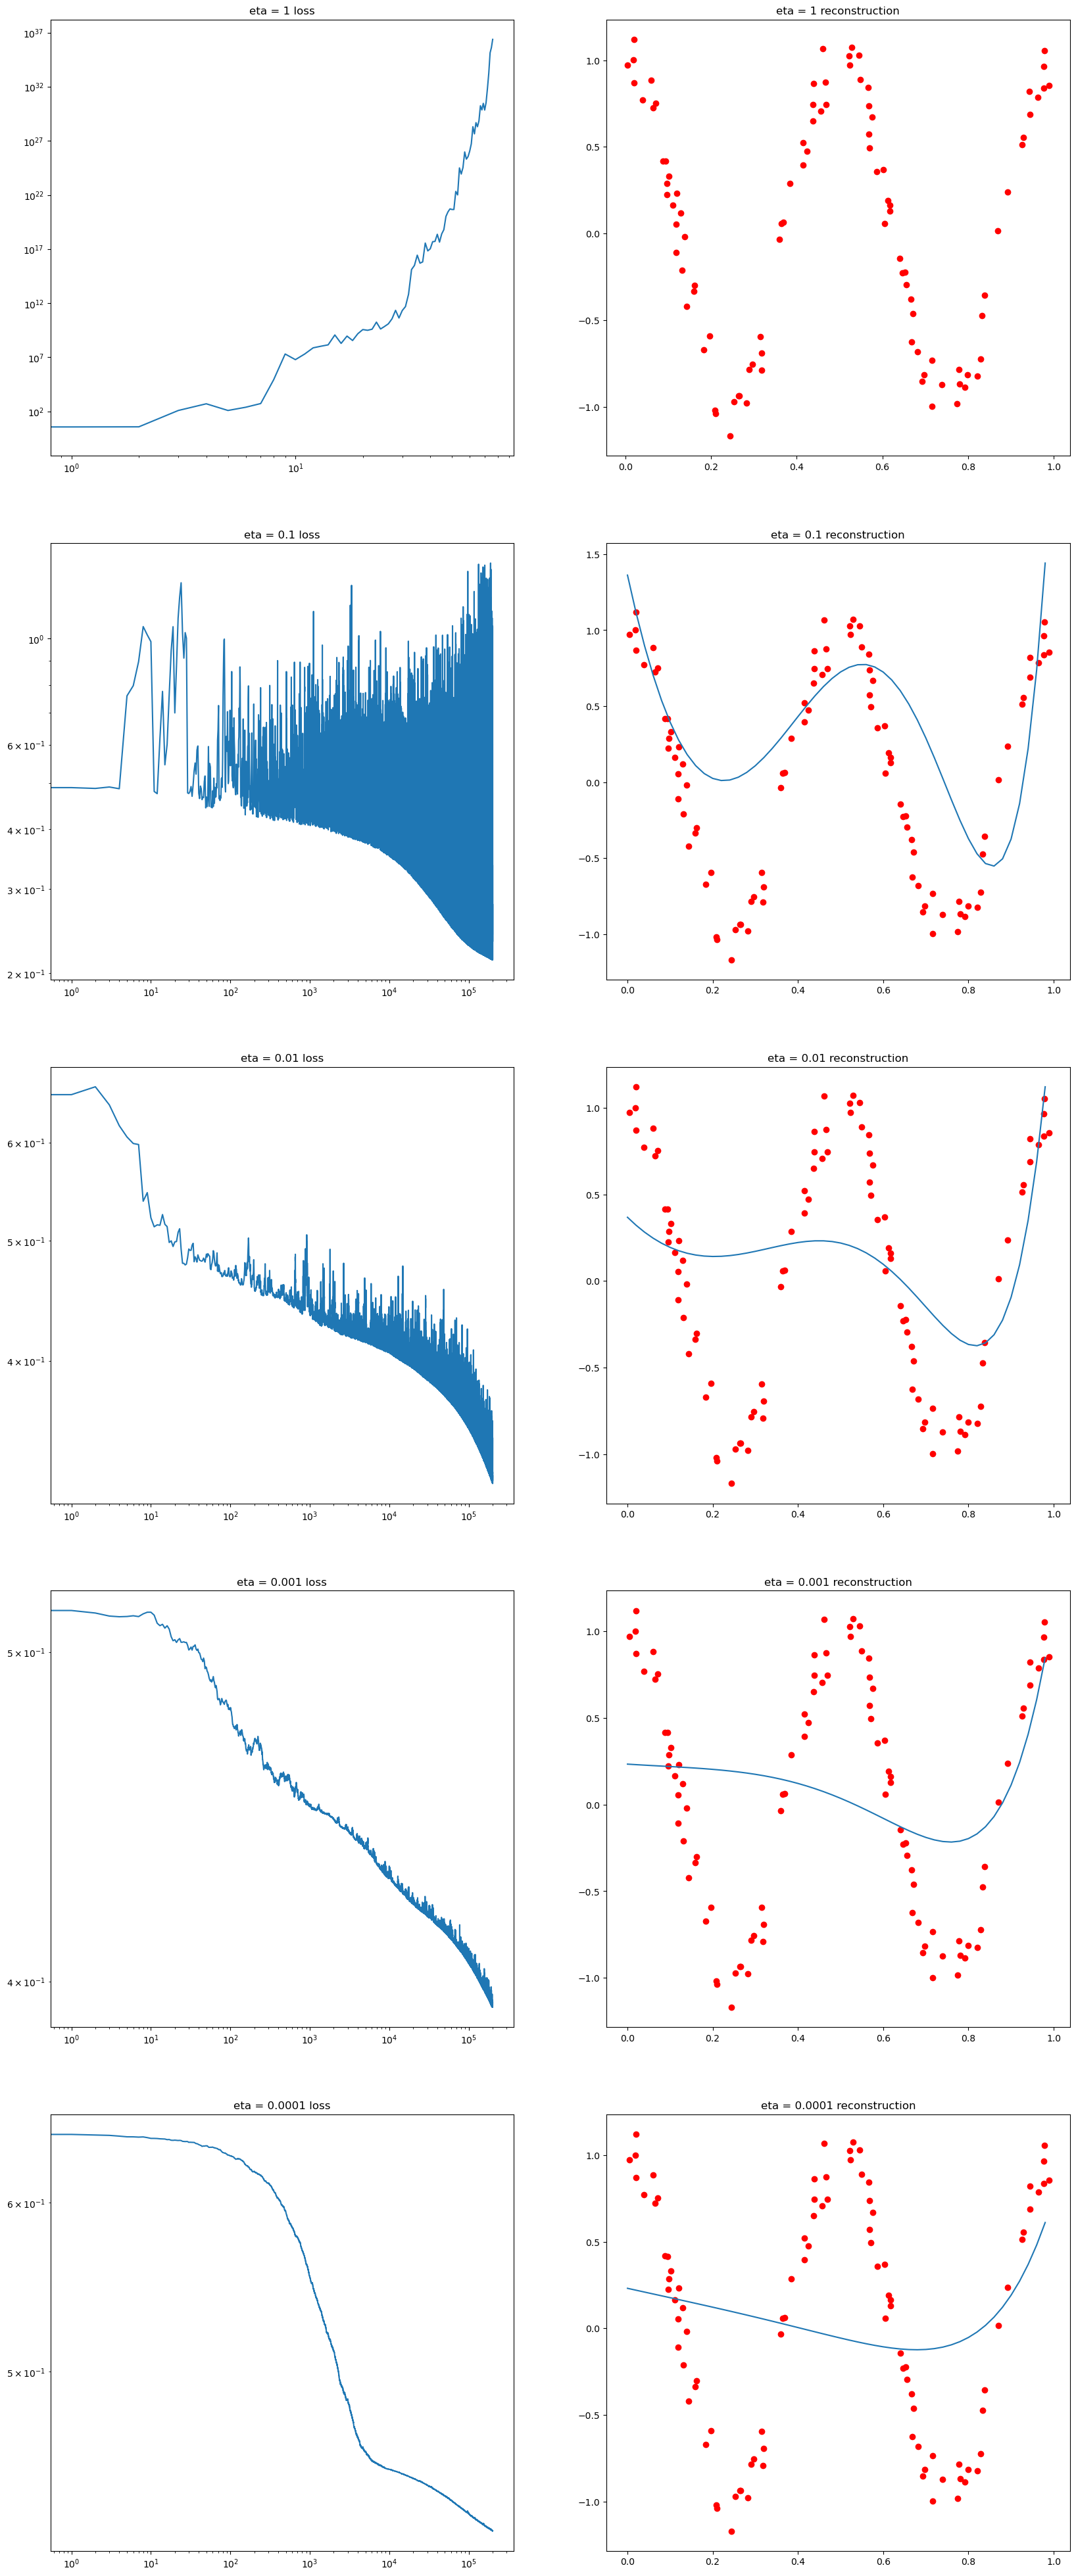

In [40]:
eta_array = [1, 1e-1, 1e-2, 1e-3, 1e-4]
n = 8
num_epochs = 200000
n_samples = len(x)
batch_size = 1 #plain SGD

fig, axs = plt.subplots(nrows=len(eta_array), ncols=2, figsize=(20,50))

grad = jax.jit(jax.grad(loss, argnums = 2))
loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)
i = 0
minimum_loss = -1
best_eta = -1

for eta in tqdm(eta_array):
    params, history_train = SGD(n, eta, x, y, initialize_params(n), grad_jit, loss_jit)

    if minimum_loss == -1 and not(np.isnan(history_train[-1])):
        minimum_loss = history_train[-1]
        best_eta = eta
    elif minimum_loss > history_train[-1]:
        minimum_loss = history_train[-1]
        best_eta = eta
    
    axs[i][0].loglog(history_train, label = 'train')
    axs[i][0].set_title(f'eta = {eta} loss')
    
    baseline = np.arange(0, 1, 2e-2)
    axs[i][1].scatter(x, y, color='red')
    axs[i][1].plot(baseline, evaluate_polinomial(baseline, params))
    axs[i][1].set_title(f'eta = {eta} reconstruction')
    i += 1

print(f'best learning rate is: {best_eta} with loss: {minimum_loss}')

### Notes
- The grade n of the polynomial does not particularly impact the obtained graph for a relatively small number of iterations. However from the theory we know that if it is too big it may cause overfitting. In particular a order 4 polynomial should already provide a good representation for the data due to it's possibility to have 3 changes of convexity.
- The learning rate proved to be a more impactfull parameter. In particular choosing it too small the convergence became too slow, changing it too big make the convergence faster but induce more variance.
- The best learning rate for a relatively low number of iteration is between 0.1 and 0.01
- The difficulty of the process of finding the best polynomial is due to the fact that the proposed function is perodic which makes the SGD easily proceed in the wrong direction

## Exercise 3
Consider a sigmoid neuron with 1D input x, weight w, bias b and output y = σ(wx + b). The target is the
variable z. Consider the cost function $J(w, b) = \frac{1}{2} (y − z)^2 $ .

• Find ∇J(w, b) and show that \begin{equation} ∥∇J∥ < \frac{1}{4} \sqrt{1 + x^2} (1 + |z|) \end{equation}

• Write the gradient descent iteration for the sequence $(w_n , b_n )$.

In [24]:
import sympy as sym

w = sym.Symbol('w')
b = sym.Symbol('b')
x = sym.Symbol('x')
y = sym.Symbol('y')

z = w*x + b
y = 1/(1 + sym.exp(-z))
grad = sym.Matrix([[sym.diff(y, w), sym.diff(y, b)]])
grad_norm = grad.norm()
grad_norm

sqrt(exp(-2*re(b) - 2*re(w*x))*Abs(x/(1 + exp(-(b + w*x)))**2)**2 + exp(-2*re(b) - 2*re(w*x))*Abs((1 + exp(-(b + w*x)))**(-2))**2)

Given this formula we proceed with the semplifications:

\begin{equation}
\sqrt{e^{-2z} \cdot (|\frac{x}{(1+e^{-z})^2}|^2 + |\frac{1}{(1+e^{-z})^2}|^2)} = \sqrt{e^-2z \cdot |\frac{1}{(1+e^{-z})^2}|^2 \cdot |x^2+1|} = e^{-z} \cdot |\frac{1}{(1+e^{-z})^2}| \cdot\sqrt{|x^2+1|} 
\end{equation}

\begin{equation}
e^{-z} \cdot |\frac{1}{(1+e^{-z})^2}| \cdot\sqrt{|x^2+1|} = \sigma(z) \cdot \frac{e^{-z}}{1+e^{-z}} \cdot\sqrt{|x^2+1|} = \sigma(z) \cdot \sigma(-z) \cdot\sqrt{|x^2+1|} 
\end{equation}

\begin{equation}
\sigma(z) \cdot \sigma(-z) \cdot\sqrt{|x^2+1|} = \sigma(z) \cdot (1 - \sigma(z)) \cdot\sqrt{|x^2+1|}
\end{equation}

Then we will simplify with the other part of the inequality

\begin{equation}
\sigma(z) \cdot (1 - \sigma(z)) \cdot\sqrt{|x^2+1|} < \frac{1}{4} \sqrt{1 + x^2} (1 + |z|)
\end{equation}

\begin{equation}
\sigma(z) \cdot (1 - \sigma(z)) < \frac{1}{4} (1 + |z|)
\end{equation}

Now we will prove that:

\begin{equation}
\sigma(z) \cdot (1 - \sigma(z)) <= \frac{1}{4}
\end{equation}

In [25]:
sigma = sym.Symbol('sigma')

In [26]:
sym.Poly(sigma*(1-sigma))

Poly(-sigma**2 + sigma, sigma, domain='ZZ')

In [27]:
sym.solve_poly_inequality((sym.Poly(sigma*(1-sigma) - 1/4, sigma)), '<')

[Interval.open(-oo, 1/2), Interval.open(1/2, oo)]

Substituting this result, if z != 1/2

\begin{equation}
\sigma(z) \cdot (1 - \sigma(z)) < \frac{1}{4} <= \frac{1}{4} (1 + |z|)
\end{equation}

otherwise:

\begin{equation}
\sigma(z) \cdot (1 - \sigma(z)) = \frac{1}{4} <= \frac{1}{4} (1 + |1/2|)=\frac{3}{2}
\end{equation}

In both cases the inequality is satisfied

The update of the parameters in the gradient descent algorithm will be computed through the following assignments:

\begin{equation}
w_{n+1} = w_n - \alpha \cdot \frac {\partial {J(w,b)}}{\partial{w}}
\end{equation}

\begin{equation}
b_{n+1} = b_n - \alpha \cdot \frac {\partial {J(w,b)}}{\partial{b}}
\end{equation}

Where $\alpha$ is the learning rate.

In our case this is equivalent to perform the following:

\begin{equation}
w_{n+1} = w_n - \alpha \cdot \frac {x e^{-b-wx}}{(e^{-b-wx}+1)^2}
\end{equation}

\begin{equation}
b_{n+1} = b_n - \alpha \cdot \frac {e^{-b-wx}}{(e^{-b-wx}+1)^2}
\end{equation}